# Project 1 Playground
Workbook for some data analysis experiments. Main goal is to explore how the self-perception of class compares to actual income. 

Cassandra Overney

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

import utils
from utils import decorate

In [2]:
# Read in GSS data
def read_gss(dirname):
    """Reads GSS files from the given directory.
    
    dirname: string
    
    returns: DataFrame
    """
    dct = utils.read_stata_dict(dirname + '/GSS.dct')
    gss = dct.read_fixed_width(dirname + '/GSS.dat')
    return gss

gss = read_gss('Project1Data')
gss.head()

,year,rincome,region,srcbelt,partyid,polviews,satjob,class_,satfin,finrela,...,wrkstat,age,educ,sex,race,hompop,babies,preteen,teens,cohort
0,1972,0,3,3,2,0,3,3,3,3,...,1,23,16,2,1,1,0,0,0,1949
1,1972,0,3,3,1,0,0,3,2,4,...,5,70,10,1,1,2,0,0,0,1902
2,1972,0,3,3,3,0,2,2,1,3,...,2,48,12,2,1,4,0,1,1,1924
3,1972,0,3,3,1,0,1,3,3,3,...,1,27,17,2,1,2,0,0,0,1945
4,1972,0,3,3,0,0,0,2,1,4,...,7,61,12,2,1,2,0,0,0,1911


First, I will include stuff I did during HW2

In [3]:
gss.realinc.replace([0], np.nan, inplace=True)
gss['class_'].replace([5, 8, 9, 0], np.nan, inplace=True)

real_incomes = gss['realinc'] # total family income in constant $1000s (1986)
real_incomes_scaled = real_incomes/1000
classes = gss['class_'] # subjective class identification

Classes have four values:
- 1: lower class
- 2: working class
- 3: middle class
- 4: upper class

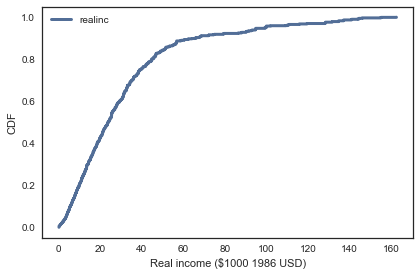

In [4]:
# Plot CDF of incomes
real_incomes_cdf = thinkstats2.Cdf(real_incomes_scaled, label='realinc')
thinkplot.Cdf(real_incomes_cdf)
decorate(xlabel='Real income ($1000 1986 USD)', ylabel='CDF')

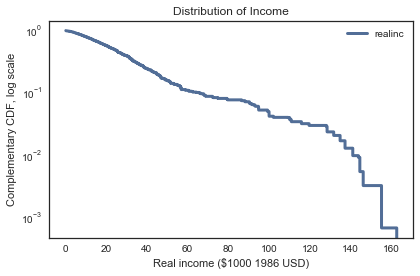

In [5]:
thinkplot.cdf(real_incomes_cdf, label='realinc', complement=True)

decorate(title='Distribution of Income', 
         xlabel='Real income ($1000 1986 USD)', 
         ylabel='Complementary CDF, log scale',
         yscale='log')

The distribution looks relatively straight. (I tried a Pareto distribution but it didn't look very straight, which raises some confusion. Maybe since this is scaled to 1986 dollars?) Doesn't look Pareto because cut off the tail. 

According to investopedia, middle class corresponds to incomes between \$40,500 and \$122,000, lower class corresponds to incomes below \$40,500, and upper class corresponds to incomes above \$122,000. GSS includes a working class which I estimate to be between \$14,000 and \$40,500, so I will break up the lower class into working and lower.     

I used an inflation calculator (https://www.usinflationcalculator.com/) to translate my 2017 income class values to 1986 amounts. Lower class is below \$6,259.79; working class is between \$6,259.79 and \$18,108.68; middle class is between \$18,108.68 and \$54,549.61; and upper class is above \$54,549.61.

In [6]:
calculated_classes = []
for income in real_incomes:
    if income > 54549.61:
        # upper class
        calculated_classes.append(4)
    elif income <= 54549.61 and income > 18108.68:
        # middle class
        calculated_classes.append(3)
    elif income <= 18108.68 and income > 6259.79:
        # working class
        calculated_classes.append(2)
    elif income <= 6259.79:
        # lower class
        calculated_classes.append(1)
calculated_classes = pd.Series(calculated_classes)
print(calculated_classes.head())

0    3
1    3
2    3
3    3
4    3
dtype: int64


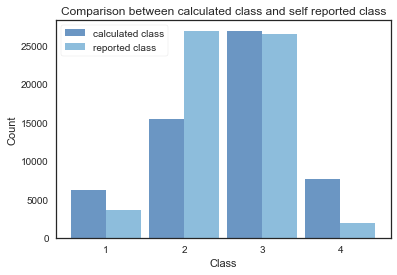

In [7]:
# Plot simple histograms for comparison
calculated_classes_hist = thinkstats2.Hist(calculated_classes, label='calculated class')
classes_hist = thinkstats2.Hist(classes, label='reported class')
width = 0.45
thinkplot.PrePlot(2)
thinkplot.Hist(calculated_classes_hist, align='right', width=width)
thinkplot.Hist(classes_hist, align='left', width=width)
thinkplot.Config(title='Comparison between calculated class and self reported class', xlabel='Class', ylabel='Count', xticks=[1, 2, 3, 4])

It seems like people may think they are in a lower class than they actually are with most people considering themselves as part of the working or middle classes. The difference is especially apparent in the working class (more people think they are in that class than they actually are). Also, more people qualify as upper class than they think. This observation is beautifully summarized by Stephen Rose's quote that “because people tend to live in communities with similar incomes, they view themselves as being near the middle because their neighbors’ circumstances are similar to their own even if their incomes are significantly below or above the US median.”

In [8]:
# Find cohen effect size
cohen = thinkstats2.CohenEffectSize(classes, calculated_classes)
cohen

-0.2521712437405217

The Cohen effect size is relatively large, indicating that reported classes tend to be lower than actual classes.

I did some more research on what constitutes different income classes and found the following information:
- Middle class means earning between 2/3 and double the median household income **after incomes have been adjusted for household size**.
- Lower income group is divided into lowest-income households and lower-middle income households (working class). Lower class means earning less than half of median. Working class means earning between 1/2 and 2/3 median. 
- Upper class means earning more than double the median
- Incomes can be adjusted for household size and scaled to reflect houseful size of three. Placed in incomes tiers based on household income in calendar year previous to survey year. 
- Adjusted income = Household income / (Household size)^N, N=0.5 since standard
- Three-person household income = Adjusted household income * [(3)^0.5]
- Median household income in US changed over time (beyond inflation), so mere inflation adjustment doesn't work. 
- Good variable for self-perception on class is **subjective class**.
- Income data adjusted for inflation using Consumer Price Index Research Series (CPI-U-RS), which is important for measures of absolute progress over time.
- Inflation-adjusted estimate = year estimate * (ref CPI-U-RS / year CPI-U-RS)

My plan is to use the realinc data and convert to constant 2015 dollars since that probably makes more sense. I got median incomes in 2015 dollars. From there I will adjust the incomes based on the household size. 

**Need to find data for median household size for median household incomes** After looking at the average median household sizes, I am fairly confident that the median household size from 1971 to 2015 is 3, so I don't need to adjust the medians for household size. 

After that, I will use newly adjusted median incomes to calculate income classes for each respondent.

In [9]:
# Read in median income data from Excel file from specific column and rows
median_income_file = 'Project1Data/median_income.xls'
median_income_df = pd.read_excel(median_income_file, index_col=None, na_values=['NA'], usecols="M").iloc[1:47]
# Generate list of years as strings
years = list(range(2015, 1970, -1))
years.insert(2, '2013_2') # Add another 2013 to account for two 2013 median incomes
print(years)
median_income_df.index = years # Set the index to years
median_income_df = median_income_df.drop(median_income_df.index[[2]]) # drop the first 2013 (has higher SE)
median_income_df

[2015, 2014, '2013_2', 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971]


,Median income (dollars)
2015,56516
2014,53718
2013,52850.1
2012,52665.9
2011,52750.6
2010,53568.2
2009,54988.4
2008,55376.2
2007,57423.3
2006,56663


In [10]:
# Convert realinc data to constant 2015 dollars
cpi_ratio = 348.9/168.6
real_incomes_2015 = real_incomes*cpi_ratio

In [11]:
# Adjust income for household size (to 3 person household)
gss['hompop'].replace([99], np.nan, inplace=True)
household_sizes = gss['hompop']
adjusted_real_incomes_2015 = (real_incomes_2015/(household_sizes**0.5))*(3**0.5)

In [21]:
# Calculate income classes
income_years = gss['year'] - 1 # minus 1 since report last year's income
income_classes = []
for index, resp_yr in enumerate(income_years):
    temp_median = median_income_df.loc[resp_yr]['Median income (dollars)']
    temp_income = adjusted_real_incomes_2015[index]
    temp_prop = temp_income/temp_median
    if temp_prop > 2:
        # upper
        income_classes.append(4)
    elif temp_prop <= 2 and temp_prop >= (2/3):
        # middle 
        income_classes.append(3)
    elif temp_prop >= (1/2) and temp_prop < (2/3):
        # working
        income_classes.append(2)
    elif temp_prop < (1/2):
        # lower
        income_classes.append(1)
    else:
        # nan
        income_classes.append(np.nan)

income_classes = pd.Series(income_classes)
print(income_classes.head())

0    3.0
1    3.0
2    3.0
3    3.0
4    4.0
dtype: float64


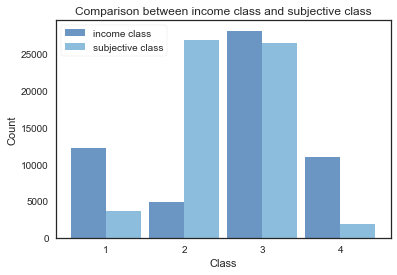

In [13]:
# Plot simple histograms for comparison
income_classes_hist = thinkstats2.Hist(income_classes, label='income class')
classes_hist = thinkstats2.Hist(classes, label='subjective class')
width = 0.45
thinkplot.PrePlot(2)
thinkplot.Hist(income_classes_hist, align='right', width=width)
thinkplot.Hist(classes_hist, align='left', width=width)
thinkplot.Config(title='Comparison between income class and subjective class', xlabel='Class', ylabel='Count', xticks=[1, 2, 3, 4])

Observations from histogram above:
- More lower income class than lower subjective class
- More respondents view themselves as being in the working or middle classes. 
- Most respondents are in the middle class. 
- More upper income class than upper subjective class.
- The most significant difference between income class and subjective class is seen in the working class. 

In [14]:
# Find cohen effect size
cohen2 = thinkstats2.CohenEffectSize(classes, income_classes)
cohen2

-0.2628451872068792

Pairwise gives Confusion matrix (guesses on one axis and reality on another axis) 4*4, numbers, colored by density 

In [24]:
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

In [23]:
print(len(income_classes), len(classes))
class_true = income_classes
class_pred = classes
confusion_matrix = ConfusionMatrix(class_true, class_pred)
print("Confusion matrix:\n%s" % confusion_matrix)

62466 62466
Confusion matrix:
Predicted   1.0    2.0    3.0   4.0  __all__
Actual                                      
1.0        2190   5696   3326   261    11473
2.0         395   2849   1360    64     4668
3.0         629  13837  11869   334    26669
4.0          42   2247   7090   991    10370
__all__    3256  24629  23645  1650    53180


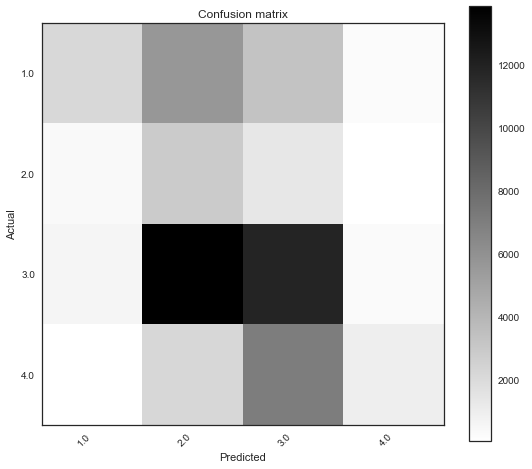

In [27]:
confusion_matrix.plot()
plt.show()

Delve into variables and confusion matrix.

My immediate next steps involve:
- Ask for confirmation on current income class calculation method (does it account for potential period effects?) Sounds reasonable
- Might have potential cohort and age effects (assume how people think about subjective class doesn't change over time)
- Attempt pairwise comparisons (confusion matrix)
- What is the distribution of subjective class and how has it changed over time?
- Look at other subjective income related variables (stfin, finrela)
- Subgroups (srcbelt, education, race, sex, region)
- Other interesting variables (wrkstat, satjob, partyid, polviews)

Resources:
- [Pew article](http://www.pewsocialtrends.org/2015/12/09/the-american-middle-class-is-losing-ground/#fnref-21084-7)
- https://www.investopedia.com/financial-edge/0912/which-income-class-are-you.aspx
- https://finance.zacks.com/lower-middle-upper-class-income-levels-9877.html
- https://en.wikipedia.org/wiki/Social_class_in_the_United_States
- https://courses.lumenlearning.com/boundless-sociology/chapter/the-class-structure-in-the-u-s/
- [Paper on Popular Conception of Class](http://ucdata.berkeley.edu/rsfcensus/papers/Hout-ClassIDJan07.pdf)
- [Census Bureau Data 2017](https://www.census.gov/library/publications/2018/demo/p60-263.html)
- [Census Bureau Data 2015](https://www.census.gov/library/publications/2016/demo/p60-256.html)
- [Census Bureau Current vs Real](https://www.census.gov/topics/income-poverty/income/guidance/current-vs-constant-dollars.html)
- [GSS Income Variables](http://gss.norc.org/Documents/reports/methodological-reports/MR064.pdf)
- ["What Is Considered Middle Class Income?"](https://www.thebalance.com/definition-of-middle-class-income-4126870)